## Select articles: look for hateful comments

In [10]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from mongoengine import connect
from hatespeech_models import Tweet, Article

client = connect("hatespeech-selection")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
Article.objects.count()

68896

In [12]:
import datetime

start_date = datetime.datetime(2020, 3, 1)

base_query = {
    "dummy__ne": True,
    "comments__19__exists": True,
    "created_at__gte": start_date,
}

articles = list(Article.objects(**base_query))

len(articles)

10314

/home/jmperez/.local/share/virtualenvs/hatespeech-selection-Vg_fyavl/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


[737400. 737450. 737500. 737550. 737600. 737650. 737700. 737750. 737800.]


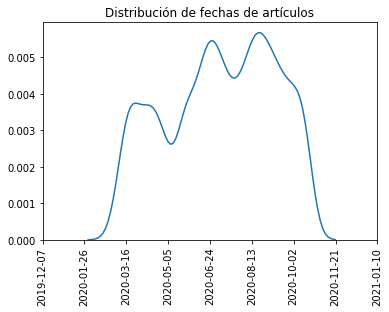

In [13]:
import seaborn as sns
import pandas as pd
import datetime
import matplotlib.pyplot as plt

dates_dist = [a.created_at for a in articles]
ordinal_dates = [d.toordinal() for d in dates_dist]
sns.distplot(ordinal_dates, kde=True, hist=False)

locations, _ = plt.xticks();
print(locations)
labels = [datetime.datetime.fromordinal(int(t)).date() for t in locations]

plt.xticks(locations, labels, rotation=90)
plt.title("Distribución de fechas de artículos");

In [14]:
for article in articles:
    hateful_comments = [c for c in article.comments if c.hateful_value > 0.5]
    
    article.num_hateful_comments = len(hateful_comments)
    article.avg_hateful_comments = len(hateful_comments) / len(article.comments)
    article.avg_hate_value = sum(c.hateful_value for c in article.comments) / len(article.comments)


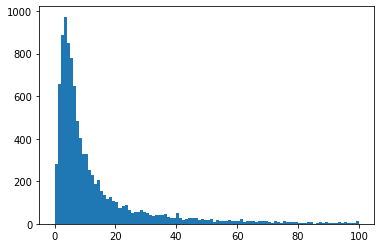

In [15]:
import matplotlib.pyplot as plt

plt.hist([c.num_hateful_comments for c in articles], range=[0, 100], bins=100);

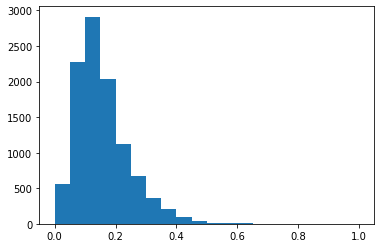

In [16]:
import matplotlib.pyplot as plt

plt.hist([c.avg_hate_value for c in articles], range=[0, 1], bins=20);

In [25]:
import random



hateful_articles = [art for art in articles if art.avg_hateful_comments > 0.4]

print(len(hateful_articles))


for art in random.sample(hateful_articles, 40):
    print("="*80)
    print(art)
    print("", art.first_paragraphs)
    
    print(art.body)

166
1289279716646703104 - LANACION (158 comentarios)
Cristina Kirchner evalúa un plan de pospandemia con dirigentes sociales
 None
La vicepresidenta recibió a dirigentes de Barrios de Pie y de la agrupación que lidera Juan Grabois Crédito: Twitter

Comentar Me gusta Me gusta Compartir E-mail Twitter Facebook WhatsApp Guardar 31 de julio de 2020 • 15:56

La vicepresidenta Cristina Kirchner recibió a dirigentes del movimiento Barrios de Pie, con quienes analizó el rol de las organizaciones sociales en el contexto de coronavirus. También, por separado, estuvo con tres dirigentes vinculadas a la agrupación de Juan Grabois para avanzar en un plan pospandemia.

La expresidenta recibió ayer al coordinador nacional de Barrios de Pie y subsecretario de Políticas de Integración y Formación de la Secretaría de Economía Social del Ministerio de Desarrollo Social, Daniel Menéndez, junto con Norma Morales, también referente de esa organización social. Menéndez se reconcilió con el kirchnerismo en 20

[737400. 737450. 737500. 737550. 737600. 737650. 737700. 737750. 737800.]


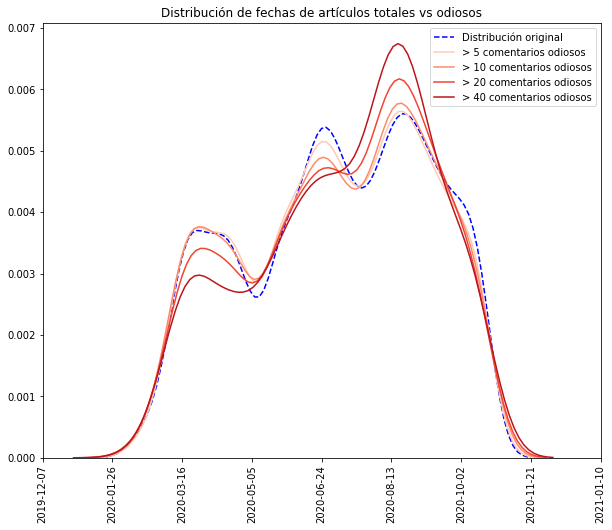

In [13]:
import random
random.seed(2020)


thresholded_hateful_articles_by_num = {
    k:[art for art in articles if art["num_hateful_comments"] >= k]
    
    for k in [5, 10, 20, 40]
}

plt.figure(figsize=(10, 8))
sns.distplot(ordinal_dates, kde=True, hist=False, color="blue", label="Distribución original", kde_kws={"linestyle": "--"})

colors = sns.color_palette("Reds", len(thresholded_hateful_articles_by_num))

for i, (k, hateful_articles) in enumerate(thresholded_hateful_articles_by_num.items()):
    hateful_dates = [art["created_at"].toordinal() for art in hateful_articles]
    sns.distplot(
        hateful_dates, kde=True, hist=False,
        label=f"> {k} comentarios odiosos",
        color=colors[i],
    )


locations, _ = plt.xticks();
print(locations)
labels = [datetime.datetime.fromordinal(int(t)).date() for t in locations]

plt.xticks(locations, labels, rotation=90)
plt.title("Distribución de fechas de artículos totales vs odiosos");

[737350. 737400. 737450. 737500. 737550. 737600. 737650. 737700. 737750.
 737800.]


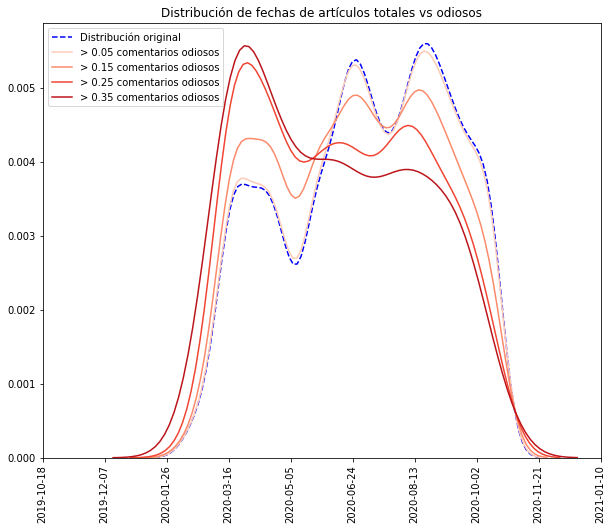

In [14]:
import random
import numpy as np

random.seed(2020)


thresholded_hateful_articles_by_comments_avg = {
    k:[art for art in articles if art["avg_hateful_comments"] > k]
    
    for k in np.arange(0.05, 0.45, 0.1)
}

plt.figure(figsize=(10, 8))
sns.distplot(ordinal_dates, kde=True, hist=False, color="blue", label="Distribución original", kde_kws={"linestyle": "--"})

colors = sns.color_palette("Reds", len(thresholded_hateful_articles_by_comments_avg))

for i, (k, hateful_articles) in enumerate(thresholded_hateful_articles_by_comments_avg.items()):
    hateful_dates = [art["created_at"].toordinal() for art in hateful_articles]
    sns.distplot(
        hateful_dates, kde=True, hist=False,
        label=f"> {k:.2f} comentarios odiosos",
        color=colors[i],
    )


locations, _ = plt.xticks();
print(locations)
labels = [datetime.datetime.fromordinal(int(t)).date() for t in locations]

plt.xticks(locations, labels, rotation=90)
plt.title("Distribución de fechas de artículos totales vs odiosos");
plt.savefig("pepe.png")

{0.05: 9877, 0.1: 7580, 0.15000000000000002: 4637, 0.2: 2577, 0.25: 1439, 0.3: 762, 0.35000000000000003: 391, 0.4: 175}
[737350. 737400. 737450. 737500. 737550. 737600. 737650. 737700. 737750.
 737800. 737850.]


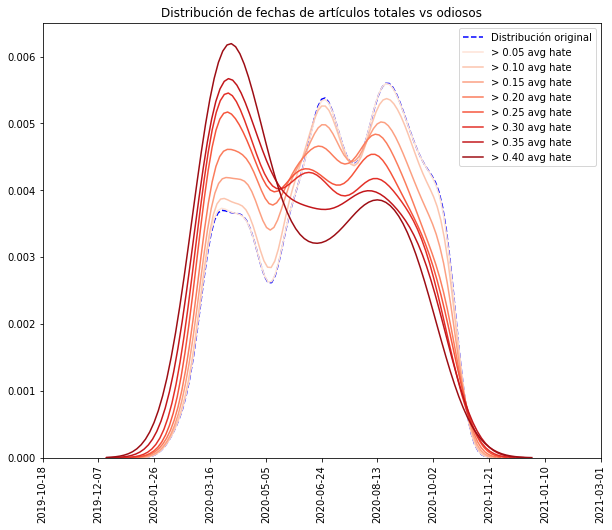

In [15]:
import random
import numpy as np

random.seed(2020)


thresholded_hateful_articles = {
    k:[art for art in articles if art["avg_hate_value"] > k]
    
    for k in np.arange(0.05, 0.45, 0.05)
}
print({k:len(art) for k, art in thresholded_hateful_articles.items()})

plt.figure(figsize=(10, 8))
sns.distplot(ordinal_dates, kde=True, hist=False, color="blue", label="Distribución original", kde_kws={"linestyle": "--"})

colors = sns.color_palette("Reds", len(thresholded_hateful_articles))

for i, (k, hateful_articles) in enumerate(thresholded_hateful_articles.items()):
    hateful_dates = [art["created_at"].toordinal() for art in hateful_articles]
    sns.distplot(
        hateful_dates, kde=True, hist=False,
        label=f"> {k:.2f} avg hate",
        color=colors[i],
    )


locations, _ = plt.xticks();
print(locations)
labels = [datetime.datetime.fromordinal(int(t)).date() for t in locations]

plt.xticks(locations, labels, rotation=90)
plt.title("Distribución de fechas de artículos totales vs odiosos");

In [22]:
for art in thresholded_hateful_articles[0.2][:100]:
    print(art)

{'_id': ObjectId('5ee598de6d0165dcb3ab419c'), 'tweet_id': 1230579275125780481, 'text': 'Alerta: confirman la primera muerte por sarampión en el país desde 1998 https://t.co/rCyYtFCHD9 https://t.co/dlpw5wJWDg', 'slug': 'alerta-confirman-la-primera-muerte-por-sarampion-en-el-pais-desde-1998_1230579275125780481', 'title': 'Alerta: confirman la primera muerte por sarampión en el país desde 1998', 'url': 'http://dlvr.it/RQR56n', 'user': 'LANACION', 'body': 'La OMS recomienda que se vacuna, al menos al 95% de la población Crédito: Shutterstock\n\nFabiola Czubaj Comentar Me gusta Me gusta Compartir E-mail Twitter Facebook WhatsApp Guardar 21 de febrero de 2020 • 00:00\n\nAyer se conocieron las dos primeras muertes en el país por dengue y sarampión. Se trata de una mujer de 50 años y un hombre de 73 años, ambos residentes en la provincia de Buenos Aires, que estaban siendo atendidos en dos centros privados de la Capital.\n\nLa mujer, que vivía en La Matanza, hacía varias semanas que estaba int